# EDA & Clustering Pipeline — Bus Trips (Price + Ratings)

This notebook performs a clean end-to-end pipeline:
1. Load data
2. Feature engineering (price & ratings)
3. Scaling with RobustScaler
4. PCA for structure inspection
5. KMeans clustering with Silhouette analysis
6. (Optional) Gaussian Mixture Model (GMM) clustering
7. Cluster profiling (interpretation)


In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


## 1. Load data

In [15]:
# Load dataset
# Assumes 'all_data.csv' is in the same folder as this notebook.
df = pd.read_csv("all_data.csv")

print("Shape:", df.shape)
df.head()

Shape: (23206, 21)


,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.7,4.7,4.6,4.6,4.9,4.7,3485,34,660
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.8,4.8,4.6,4.6,4.9,4.6,237,34,645
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.4,4.4,4.7,4.5,8677,24,705
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,0,2025-11-12,Sài Gòn,Gia Lai,...,4.6,4.7,4.6,4.5,4.5,4.5,4.6,1135,34,660
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.5,4.5,4.9,4.7,1027,34,625


In [16]:
# Quick info & numeric summary
display(df.info())
display(df.describe(include="number").T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23206 entries, 0 to 23205
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_name              23206 non-null  object 
 1   departure_time            23206 non-null  object 
 2   pickup_point              23206 non-null  object 
 3   arrival_time              23206 non-null  object 
 4   dropoff_point             23206 non-null  object 
 5   price_original            23206 non-null  int64  
 6   price_discounted          23206 non-null  int64  
 7   departure_date            23206 non-null  object 
 8   start_point               23206 non-null  object 
 9   destination               23206 non-null  object 
 10  rating_safety             23206 non-null  float64
 11  rating_info_accuracy      23206 non-null  float64
 12  rating_info_completeness  23206 non-null  float64
 13  rating_staff_attitude     23206 non-null  float64
 14  rating

None

,count,mean,std,min,25%,50%,75%,max
price_original,23206.0,333291.217789,158613.762383,0.0,220000.0,300000.0,410000.0,1200000.0
price_discounted,23206.0,132604.716582,172687.445566,0.0,0.0,0.0,270000.0,900000.0
rating_safety,23206.0,4.584056,0.362669,2.3,4.5,4.7,4.8,5.0
rating_info_accuracy,23206.0,4.450086,0.471081,1.0,4.2,4.6,4.8,5.0
rating_info_completeness,23206.0,4.510101,0.424047,1.0,4.3,4.6,4.8,5.0
rating_staff_attitude,23206.0,4.485125,0.430549,1.0,4.3,4.6,4.8,5.0
rating_comfort,23206.0,4.435719,0.465403,1.0,4.2,4.6,4.7,5.0
rating_service_quality,23206.0,4.401935,0.478436,1.0,4.2,4.5,4.7,5.0
rating_punctuality,23206.0,4.612234,0.467783,1.0,4.5,4.7,4.8,5.0
rating_overall,23206.0,4.425170,0.492151,0.0,4.2,4.6,4.8,5.0


---

## 2. Feature Engineering

In [ ]:
def handle_price_discounted(df,):
    df.loc[df['price_discounted'] == 0, 'price_discounted'] = df['price_original']
    return df

def add_time_hour(df: pd.DataFrame, time_col: str, new_col: str) -> pd.DataFrame:
    """
    Convert HH:MM:SS or HH:MM time to hour (0–23). 
    If minutes > 30, round up to next hour.
    """
    time_split = df[time_col].str.split(":", expand=True)
    time_split = time_split.astype("Int64")
    
    condition = time_split[1] > 30
    time_split.loc[condition, 0] += 1
    time_split[0] = time_split[0].replace(24, 0)
    
    df[new_col] = time_split[0].astype("int64")
    return df


def add_date_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Ensure date_col is datetime and add ISO weekday (1=Mon,...,7=Sun).
    """
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["ISO_Weekday"] = df[date_col].dt.isoweekday()
    return df


def add_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add discount_rate and price_per_minute.
    """
    df["discount_rate"] = (df["price_original"] - df["price_discounted"]) / df["price_original"].replace(0, np.nan)
    df["discount_rate"] = df["discount_rate"].fillna(0)
    
    # Avoid division by zero for duration
    duration = df["duration_minutes"].replace(0, np.nan)
    df["price_per_minute"] = df["price_discounted"] / duration
    df["price_per_minute"] = df["price_per_minute"].fillna(0)
    return df


def add_rating_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Kết hợp các thuộc tính đánh giá thành các chỉ số tổng hợp
    """
    quality_cols = [
        "rating_comfort",
        "rating_service_quality",
        "rating_staff_attitude",
    ]
    info_cols = [
        "rating_info_accuracy",
        "rating_info_completeness",
    ]
    
    df["rating_quality"] = df[quality_cols].mean(axis=1)
    df["rating_info"] = df[info_cols].mean(axis=1)
    
    # Value for money: overall rating per unit price
    df["value_index"] = df["rating_overall"] / df["price_discounted"].replace(0, np.nan)
    df["value_index"] = df["value_index"].fillna(0)
    
    return df

In [18]:
# Apply feature engineering

df = add_time_hour(df, "departure_time", "departure_time_hour")
df = add_time_hour(df, "arrival_time", "arrival_time_hour")
# df = add_date_features(df, "departure_date")
df = add_price_features(df)
df = handle_price_discounted(df)
df = add_rating_features(df)

df[
    [
        "price_original",
        "price_discounted",
        "discount_rate",
        "price_per_minute",
        "rating_overall",
        "rating_quality",
        "rating_info",
        "rating_safety",
        "rating_punctuality",
        "value_index",
        "duration_minutes",
        "reviewer_count",
    ]
].describe().T

,count,mean,std,min,25%,50%,75%,max
price_original,23206.0,333291.217789,158613.762383,0.00,220000.000000,300000.000000,410000.000000,1.200000e+06
price_discounted,23206.0,309107.129751,148156.703520,0.00,210000.000000,290000.000000,382500.000000,1.200000e+06
discount_rate,23206.0,0.605492,0.433414,0.00,0.111111,1.000000,1.000000,1.000000e+00
price_per_minute,23206.0,447.463405,607.061770,0.00,0.000000,0.000000,800.000000,5.343750e+03
rating_overall,23206.0,4.425170,0.492151,0.00,4.200000,4.600000,4.800000,5.000000e+00
rating_quality,23206.0,4.440926,0.448751,1.00,4.233333,4.533333,4.733333,5.000000e+00
rating_info,23206.0,4.480094,0.435965,2.35,4.250000,4.600000,4.800000,5.000000e+00
rating_safety,23206.0,4.584056,0.362669,2.30,4.500000,4.700000,4.800000,5.000000e+00
rating_punctuality,23206.0,4.612234,0.467783,1.00,4.500000,4.700000,4.800000,5.000000e+00
value_index,23206.0,0.000017,0.000009,0.00,0.000011,0.000016,0.000021,7.142857e-05


## Outlier Overview (IQR-based)

In [19]:
def iqr_outlier_ratio(series: pd.Series, k: float = 1.5) -> float:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    mask = (series < lower) | (series > upper)
    return mask.mean()


num_cols = [
    "price_original",
    "price_discounted",
    "discount_rate",
    "price_per_minute",
    "rating_overall",
    "rating_quality",
    "rating_info",
    "rating_safety",
    "rating_punctuality",
    "value_index",
    "reviewer_count",
    "duration_minutes",
]

outlier_stats = []
for col in num_cols:
    ratio = iqr_outlier_ratio(df[col].dropna())
    outlier_stats.append({"column": col, "outlier_ratio": ratio})

outlier_df = pd.DataFrame(outlier_stats).sort_values("outlier_ratio", ascending=False)
outlier_df

,column,outlier_ratio
10,reviewer_count,0.106610
8,rating_punctuality,0.074808
7,rating_safety,0.073257
9,value_index,0.049729
0,price_original,0.048306
4,rating_overall,0.045031
1,price_discounted,0.043653
5,rating_quality,0.037835
6,rating_info,0.036887
3,price_per_minute,0.020210


## Prepare Data for Clustering

In [20]:
# Final feature set focusing on price + ratings
features = [
    "price_discounted",
    "discount_rate",
    "price_per_minute",
    "value_index",
    "rating_overall",
    "rating_quality",
    "rating_info",
    "rating_safety",
    "rating_punctuality",
    "reviewer_count",
]

X = df[features].copy()

# Fill any remaining missing values with column median
X = X.fillna(X.median())

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 5.79710145e-02, -9.64285714e-01,  5.68181818e-01,
        -1.93202273e-02,  1.66666667e-01,  2.00000000e-01,
         1.81818182e-01,  3.33333333e-01,  6.66666667e-01,
         1.32743363e+00],
       [ 3.47826087e-02, -9.00000000e-01,  5.73643411e-01,
        -3.17908351e-02,  0.00000000e+00,  2.66666667e-01,
         2.72727273e-01,  0.00000000e+00,  6.66666667e-01,
        -1.09734513e-01],
       [ 6.31884058e-01, -8.46933962e-01,  7.07446809e-01,
        -4.53226385e-01, -1.66666667e-01, -2.00000000e-01,
        -9.09090909e-02, -6.66666667e-01,  0.00000000e+00,
         3.62477876e+00],
       [ 3.47826087e-01,  0.00000000e+00,  0.00000000e+00,
        -2.68859634e-01,  0.00000000e+00, -1.77635684e-15,
         9.09090909e-02,  0.00000000e+00, -6.66666667e-01,
         2.87610619e-01],
       [ 5.79710145e-02, -9.64285714e-01,  6.00000000e-01,
        -1.93202273e-02,  1.66666667e-01, -6.66666667e-02,
        -9.09090909e-02, -3.33333333e-01,  6.66666667e-01,
         2.

## PCA: Inspect Structure

Explained variance (2 components): 0.6814882931850894


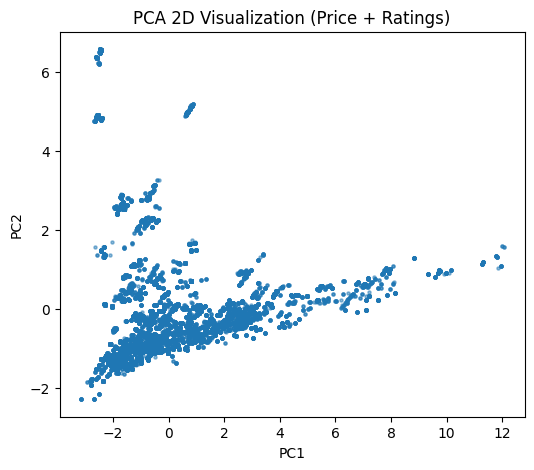

In [21]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance (2 components):", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization (Price + Ratings)")
plt.show()

## KMeans: Silhouette Analysis

In [22]:
results_kmeans = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    results_kmeans.append((k, score))

for k, score in results_kmeans:
    print(f"Number of clusters: {k}, Silhouette Score: {score:.4f}")

best_k, best_score = max(results_kmeans, key=lambda x: x[1])
print("\nBest KMeans k:", best_k, "with Silhouette:", round(best_score, 4))

Number of clusters: 2, Silhouette Score: 0.3929
Number of clusters: 3, Silhouette Score: 0.3880
Number of clusters: 4, Silhouette Score: 0.3327
Number of clusters: 5, Silhouette Score: 0.2478
Number of clusters: 6, Silhouette Score: 0.2288
Number of clusters: 7, Silhouette Score: 0.2431
Number of clusters: 8, Silhouette Score: 0.2417

Best KMeans k: 2 with Silhouette: 0.3929


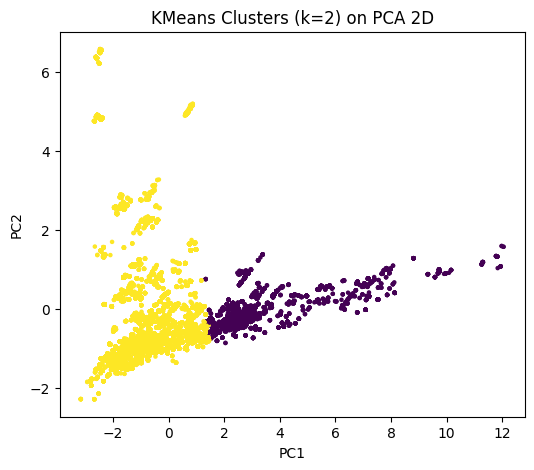

,price_discounted,discount_rate,price_per_minute,value_index,rating_overall,rating_quality,rating_info,rating_safety,rating_punctuality,reviewer_count
cluster_kmeans,,,,,,,,,,
0,413295.95,0.73,247.69,0.0,3.67,3.74,3.78,4.02,4.03,452.93
1,285125.59,0.58,493.45,0.0,4.60,4.60,4.64,4.71,4.75,2444.91


In [23]:
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster_kmeans"] = best_kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster_kmeans"], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) on PCA 2D")
plt.show()

df.groupby("cluster_kmeans")[features].mean().round(2)

## Gaussian Mixture Model (GMM): Silhouette Analysis

In [24]:
results_gmm = []

for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    results_gmm.append((k, score))

for k, score in results_gmm:
    print(f"GMM components: {k}, Silhouette Score: {score:.4f}")

best_gmm_k, best_gmm_score = max(results_gmm, key=lambda x: x[1])
print("\nBest GMM components:", best_gmm_k, "with Silhouette:", round(best_gmm_score, 4))

GMM components: 2, Silhouette Score: 0.2274
GMM components: 3, Silhouette Score: 0.0660
GMM components: 4, Silhouette Score: 0.1247
GMM components: 5, Silhouette Score: 0.0545
GMM components: 6, Silhouette Score: 0.0818
GMM components: 7, Silhouette Score: 0.0492
GMM components: 8, Silhouette Score: 0.0671

Best GMM components: 2 with Silhouette: 0.2274


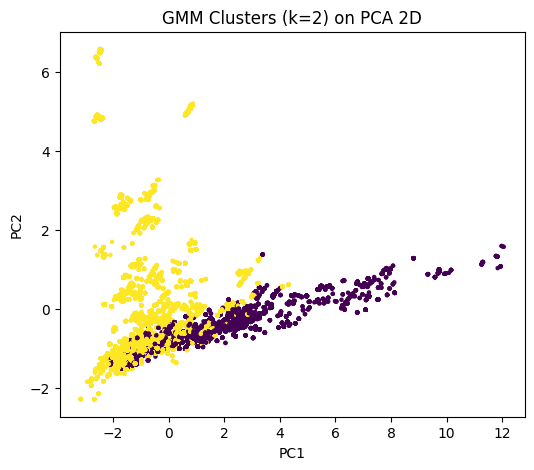

,price_discounted,discount_rate,price_per_minute,value_index,rating_overall,rating_quality,rating_info,rating_safety,rating_punctuality,reviewer_count
cluster_gmm,,,,,,,,,,
0,366298.49,0.85,134.58,0.0,3.96,4.03,4.05,4.26,4.29,214.61
1,288435.03,0.52,560.56,0.0,4.59,4.59,4.63,4.70,4.73,2743.63


In [25]:
best_gmm = GaussianMixture(n_components=best_gmm_k, random_state=42)
df["cluster_gmm"] = best_gmm.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster_gmm"], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"GMM Clusters (k={best_gmm_k}) on PCA 2D")
plt.show()

df.groupby("cluster_gmm")[features].mean().round(2)

In [26]:
df.groupby("cluster_kmeans")[[
    "price_discounted",
    "discount_rate",
    "price_per_minute",
    "value_index",

    "rating_overall",
    "rating_quality",
    "rating_info",
    "rating_safety",
    "rating_punctuality",

    "reviewer_count",
]].mean().round(2)


,price_discounted,discount_rate,price_per_minute,value_index,rating_overall,rating_quality,rating_info,rating_safety,rating_punctuality,reviewer_count
cluster_kmeans,,,,,,,,,,
0,413295.95,0.73,247.69,0.0,3.67,3.74,3.78,4.02,4.03,452.93
1,285125.59,0.58,493.45,0.0,4.60,4.60,4.64,4.71,4.75,2444.91
